# Predicting sentiment from product reviews

### Due: Wednesday, April 25th, at 11:59 pm on Canvas

The goal of this first notebook is to explore logistic regression and feature engineering with existing Turi Create functions.

In this notebook you will use product review data from Amazon.com to predict whether the sentiments about a product (from its reviews) are positive or negative.

* Use SFrames to do some feature engineering
* Train a logistic regression model to predict the sentiment of product reviews.
* Inspect the weights (coefficients) of a trained logistic regression model.
* Make a prediction (both class and probability) of sentiment for a new product review.
* Given the logistic regression weights, predictors and ground truth labels, write a function to compute the **accuracy** of the model.
* Inspect the coefficients of the logistic regression model and interpret their meanings.
* Compare multiple logistic regression models.

Copyright ©2018 Emily Fox.  All rights reserved.  Permission is hereby granted to students registered for University of Washington CSE/STAT 416 for use solely during Spring Quarter 2018 for purposes of the course.  No other use, copying, distribution, or modification is permitted without prior written consent. Copyrights for third-party components of this work must be honored.  Instructors interested in reusing these course materials should contact the author.


In [1]:
from __future__ import division
import turicreate as tc
import math
import string
import matplotlib.pyplot as plt
%matplotlib inline

# Data preperation

We will use a dataset consisting of baby product reviews on Amazon.com.

In [2]:
products = tc.SFrame('/data/amazon_baby_subset.gl')
products

name,review,rating
Stop Pacifier Suckingwithout tears with ...,All of my kids have criednon-stop when I tried to ...,5.0
Nature's Lullabies SecondYear Sticker Calendar ...,We wanted to getsomething to keep track ...,5.0
Nature's Lullabies SecondYear Sticker Calendar ...,I only purchased asecond-year calendar for ...,2.0
Nature's Lullabies SecondYear Sticker Calendar ...,My daughter had her 1stbaby over a year ago. ...,5.0
"Lamaze Peekaboo, I LoveYou ...","One of baby's first andfavorite books, and i ...",4.0
"SoftPlay Giggle JiggleFunbook, Happy Bear ...",This bear is absolutelyadorable and I would ...,2.0
SoftPlay Peek-A-BooWhere's Elmo A Childr ...,Very cute interactivebook! My son loves this ...,5.0
"SoftPlay Cloth Book, Love",This book is boring.Nothing to stimulate my ...,1.0
Our Baby Girl Memory Book,"Beautiful book, I love itto record cherished t ...",5.0
Hunnt&reg; FallingFlowers and Birds Kids ...,"Try this out for a springproject !Easy ,fun and ...",5.0


Now, let us see a preview of what the dataset looks like.

## Build the word count vector for each review

Let us explore a specific example of a baby product.


In [3]:
products[210]

{'name': 'Summer Infant, Ultimate Training Pad - Twin Mattress, 38&quot; x 28&quot;',
 'rating': 5.0,
 'review': 'Love this thing.. what a bed saver... I was finishing potty training my 2 year old and bed time was my biggest concern.  But with this I do not have to worry about the foam mattress I have on my daughters bed.  It is easy to wash and put back on the bed.. love this thing.'}

Now, we will perform 2 simple data transformations:

1. Remove punctuation using [Python's built-in](https://docs.python.org/2/library/string.html) string functionality.
2. Transform the reviews into word-counts.

**Aside**. In this notebook, we remove all punctuations for the sake of simplicity. A smarter approach to punctuations would preserve phrases such as "I'd", "would've", "hadn't" and so forth. See [this page](ftp://ftp.cis.upenn.edu/pub/treebank/public_html/tokenization.html) for an example of smart handling of punctuations.

In [4]:
def remove_punctuation(text):
    return text.translate(None, string.punctuation) 

products['review_clean'] = products['review'].apply(remove_punctuation)
products['word_count'] = tc.text_analytics.count_words(products['review_clean'])
products

Using default 16 lambda workers.

To maximize the degree of parallelism, add the following code to the beginning of the program:

"turicreate.config.set_runtime_config('TURI_DEFAULT_NUM_PYLAMBDA_WORKERS', 24)"

Note that increasing the degree of parallelism also increases the memory footprint.

name,review,rating,review_clean
Stop Pacifier Suckingwithout tears with ...,All of my kids have criednon-stop when I tried to ...,5.0,All of my kids have criednonstop when I tried to ...
Nature's Lullabies SecondYear Sticker Calendar ...,We wanted to getsomething to keep track ...,5.0,We wanted to getsomething to keep track ...
Nature's Lullabies SecondYear Sticker Calendar ...,I only purchased asecond-year calendar for ...,2.0,I only purchased asecondyear calendar for ...
Nature's Lullabies SecondYear Sticker Calendar ...,My daughter had her 1stbaby over a year ago. ...,5.0,My daughter had her 1stbaby over a year ago She ...
"Lamaze Peekaboo, I LoveYou ...","One of baby's first andfavorite books, and i ...",4.0,One of babys first andfavorite books and it is ...
"SoftPlay Giggle JiggleFunbook, Happy Bear ...",This bear is absolutelyadorable and I would ...,2.0,This bear is absolutelyadorable and I would ...
SoftPlay Peek-A-BooWhere's Elmo A Childr ...,Very cute interactivebook! My son loves this ...,5.0,Very cute interactivebook My son loves this ...
"SoftPlay Cloth Book, Love",This book is boring.Nothing to stimulate my ...,1.0,This book is boringNothing to stimulate my ...
Our Baby Girl Memory Book,"Beautiful book, I love itto record cherished t ...",5.0,Beautiful book I love itto record cherished t ...
Hunnt&reg; FallingFlowers and Birds Kids ...,"Try this out for a springproject !Easy ,fun and ...",5.0,Try this out for a springproject Easy fun and ...


Now, let us explore what the sample example above looks like after these 2 transformations. Here, each entry in the **word_count** column is a dictionary where the key is the word and the value is a count of the number of times the word occurs.

In [5]:
products[210]['word_count']
len(products)

52449

## Extract sentiments

We will **ignore** all reviews with *rating = 3*, since they tend to have a neutral sentiment.

In [6]:
products = products[products['rating'] != 3]
len(products)

52448

Now, we will assign reviews with a rating of 4 or higher to be *positive* reviews, while the ones with rating of 2 or lower are *negative*. For the sentiment column, we use +1 for the positive class label and -1 for the negative class label.

In [7]:
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)
products

name,review,rating,review_clean
Stop Pacifier Suckingwithout tears with ...,All of my kids have criednon-stop when I tried to ...,5.0,All of my kids have criednonstop when I tried to ...
Nature's Lullabies SecondYear Sticker Calendar ...,We wanted to getsomething to keep track ...,5.0,We wanted to getsomething to keep track ...
Nature's Lullabies SecondYear Sticker Calendar ...,I only purchased asecond-year calendar for ...,2.0,I only purchased asecondyear calendar for ...
Nature's Lullabies SecondYear Sticker Calendar ...,My daughter had her 1stbaby over a year ago. ...,5.0,My daughter had her 1stbaby over a year ago She ...
"Lamaze Peekaboo, I LoveYou ...","One of baby's first andfavorite books, and i ...",4.0,One of babys first andfavorite books and it is ...
"SoftPlay Giggle JiggleFunbook, Happy Bear ...",This bear is absolutelyadorable and I would ...,2.0,This bear is absolutelyadorable and I would ...
SoftPlay Peek-A-BooWhere's Elmo A Childr ...,Very cute interactivebook! My son loves this ...,5.0,Very cute interactivebook My son loves this ...
"SoftPlay Cloth Book, Love",This book is boring.Nothing to stimulate my ...,1.0,This book is boringNothing to stimulate my ...
Our Baby Girl Memory Book,"Beautiful book, I love itto record cherished t ...",5.0,Beautiful book I love itto record cherished t ...
Hunnt&reg; FallingFlowers and Birds Kids ...,"Try this out for a springproject !Easy ,fun and ...",5.0,Try this out for a springproject Easy fun and ...


Now, we can see that the dataset contains an extra column called **sentiment** which is either positive (+1) or negative (-1).

## Split data into training and test sets

Let's perform a train/test split with 80% of the data in the training set and 20% of the data in the test set. We use `seed=1` so that everyone gets the same result.

In [8]:
train_data, test_data = products.random_split(.8, seed=1)
print len(train_data)
print len(test_data)
test_data

41985
10463


name,review,rating,review_clean
Our Baby Girl Memory Book,"Beautiful book, I love itto record cherished t ...",5.0,Beautiful book I love itto record cherished t ...
Hunnt&reg; FallingFlowers and Birds Kids ...,"Try this out for a springproject !Easy ,fun and ...",5.0,Try this out for a springproject Easy fun and ...
Cloth Diaper PinsStainless Steel ...,These were good quality--worked fine--heavy ...,2.0,These were goodqualityworked fineheavy ...
Cloth Diaper PinsStainless Steel ...,I really thought I wasgetting a dozen ...,2.0,I really thought I wasgetting a dozen pinst ...
Newborn Baby Tracker&reg;- Round the Clock ...,I received this at mybaby shower and it has ...,5.0,I received this at mybaby shower and it has ...
my first fish bowl bylamaze / learning curve ...,We first bought this toyfor our oldest child ...,5.0,We first bought this toyfor our oldest child ...
my first fish bowl bylamaze / learning curve ...,This toy was given to myson by his grandmother. ...,2.0,This toy was given to myson by his grandmothe ...
Fisher Price NestingAction Vehicles ...,We bought these trucksfor our 15 mo. old ...,5.0,We bought these trucksfor our 15 mo old ...
Fisher Price NestingAction Vehicles ...,We just bought this formy 9 month old ...,5.0,We just bought this formy 9 month old ...
Lullaby and Goodnight byPockets of Learning ...,I ordered this book forthe up-coming birthda ...,4.0,I ordered this book forthe upcoming birthday of ...


## Baseline: Majority class prediction

It is quite common to use the **majority class classifier** as the a baseline (or reference) model for comparison with your classifier model. The majority classifier model predicts the majority class for all data points. At the very least, you should healthily beat the majority class classifier, otherwise, the model is (usually) pointless.

What is the majority class in the **train_data**?

In [9]:
num_positive  = (train_data['sentiment'] == +1).sum()
num_negative = (train_data['sentiment'] == -1).sum()
print num_positive
print num_negative

20949
21036


Now compute the accuracy of the majority class classifier on **test_data**.

**Quiz Question**: Enter the accuracy of the majority class classifier model on the **test_data**. Round your answer to two decimal places (e.g. 0.76).

In [10]:
num_positive_test  = (test_data['sentiment'] == +1).sum()
pos_percent_test = num_positive_test * 1.0 / len(test_data)
print(pos_percent_test)
pos_percent_train = num_positive * 1.0 / len(train_data)
print(pos_percent_train)
accuracy = pos_percent_train / pos_percent_test
print(accuracy)

0.509796425499
0.498963915684
0.978751302925


# Train a sentiment classifier with logistic regression

We will now use logistic regression to create a sentiment classifier on the training data. This model will use the column **word_count** as a feature and the column **sentiment** as the target. We will use `validation_set=None` to obtain same results as everyone else, and set the `l1_penalty=0` and `l2_penalty=0`.

**Note:** This line may take 1-2 minutes.

In [11]:
sentiment_model = tc.logistic_classifier.create(train_data,
                                                target = 'sentiment',
                                                features=['word_count'],
                                                validation_set=None, l1_penalty=0, l2_penalty=0)
sentiment_model

WARNING: The number of feature dimensions in this problem is very large in comparison with the number of examples. Unless an appropriate regularization value is set, this model may not provide accurate predictions for a validation/test set.

Logistic regression:

--------------------------------------------------------

Number of examples          : 41985

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 61175

Number of coefficients      : 61176

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-accuracy |

+-----------+----------+-----------+--------------+-------------------+

| 1         | 3        | 0.000024  | 1.214094     | 0.815625          |

| 2         | 5        | 1.000000  | 1.370536     | 0.928474          |

| 3         | 6        | 1.000000  | 1.463615     | 0.936882          |

| 4         | 7        | 1.000000  | 1.560847     | 0.962653          |

| 5         | 8        | 1.000000  | 1.655655     | 0.972824          |

| 6         | 9        | 1.000000  | 1.751281     | 0.943575          |

| 10        | 14       | 1.000000  | 2.260004     | 0.983851          |

+-----------+----------+-----------+--------------+-------------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

Class                          : LogisticClassifier

Schema
------
Number of coefficients         : 61176
Number of examples             : 41985
Number of classes              : 2
Number of feature columns      : 1
Number of unpacked features    : 61175

Hyperparameters
---------------
L1 penalty                     : 0.0
L2 penalty                     : 0.0

Training Summary
----------------
Solver                         : lbfgs
Solver iterations              : 10
Solver status                  : TERMINATED: Iteration limit reached.
Training time (sec)            : 2.3063

Settings
--------
Log-likelihood                 : 2572.0479

Highest Positive Coefficients
-----------------------------
word_count[themside]           : 12.3049
word_count[lat]                : 11.3296
word_count[unsize]             : 9.5576
word_count[3but]               : 8.9714
word_count[110f]               : 8.9205

Lowest Negative Coefficients
----------------------------
word_count[chairsthere]        : -1

In [12]:
sentiment_model.coefficients


name,index,class,value,stderr
(intercept),None,1,0.0594285255049,None
word_count,rock,1,-0.224703091957,None
word_count,headachesthanks,1,1.65486590536,None
word_count,soo,1,-0.244120041722,None
word_count,expecting,1,0.085960910195,None
word_count,save,1,-0.740196912465,None
word_count,for,1,0.0417948806631,None
word_count,many,1,0.189948219369,None
word_count,great,1,0.852105887998,None
word_count,a,1,0.0132563638251,None


Now that we have fitted the model, we can extract the weights (coefficients) as an SFrame as follows:

In [13]:
weights = sentiment_model.coefficients
weights.column_names()
len(weights)
weights

name,index,class,value,stderr
(intercept),None,1,0.0594285255049,None
word_count,rock,1,-0.224703091957,None
word_count,headachesthanks,1,1.65486590536,None
word_count,soo,1,-0.244120041722,None
word_count,expecting,1,0.085960910195,None
word_count,save,1,-0.740196912465,None
word_count,for,1,0.0417948806631,None
word_count,many,1,0.189948219369,None
word_count,great,1,0.852105887998,None
word_count,a,1,0.0132563638251,None


There are a total of `61176` coefficients in the model. Recall from the lecture that positive weights $w_j$ correspond to weights that cause positive sentiment, while negative weights correspond to negative sentiment. 

Fill in the following block of code to calculate how many *weights* are positive ( >= 0). (**Hint**: The `'value'` column in SFrame *weights* must be positive ( >= 0)).

In [14]:
print "Number of positive weights: %s " % len(weights[weights['value'] >=0])
print "Number of negative weights: %s " % len(weights[weights['value'] <0])

Number of positive weights: 28662 
Number of negative weights: 32514 


**Quiz question:** How many weights are >= 0?

## Making predictions with logistic regression

Now that a model is trained, we can make predictions on the **test data**. In this section, we will explore this in the context of 3 examples in the test dataset.  We refer to this set of 3 examples as the **sample_test_data**.

In [15]:
sample_test_data = test_data[10:13]

Let's dig deeper into the first row of the **sample_test_data**. Here's the full review:

In [16]:
sample_test_data[0]['review']

"This is a must have for any toddler!  I bought one for my brothers triplets who were 1 1/2 years old at the time.  They loved it!  One would push & the other 2 would chase after it.  They love watching the duck waddle & its feet go round & round.  Best of all, no batteries!  Yaayyyy!!Fifteen years ago, I bought my daughter a little push clown from the same company.  It was her favorite toy & was passed onto her brother.  With heavy playing by 2 children it never lost any of its paint or parts.  It's something we are saving for grandchildren one day."

That review seems pretty positive.

Now, let's see what the another row of the **sample_test_data** looks like. As we could guess from the sentiment (-1), the review is quite negative.

In [17]:
sample_test_data[2]['review']

'I would recommend getting cheaper sheets made for a playpen. These started unraveling after one wash! Not worth the money.'

### Predicting sentiment


Run the following Turi Create code to make predictions.

In [18]:
print "Probability predictions on the sample test data:" 
print sentiment_model.predict(sample_test_data, output_type='probability')

Probability predictions on the sample test data:
[0.996289053384975, 0.6859062765578067, 0.19121671558056869]


** Quiz question:** Of the three data points in **sample_test_data**, which one (first, second, or third) has the **lowest probability** of being classified as a positive review?

In [19]:
print "Predicted labels on the sample test data:" 
print sentiment_model.predict(sample_test_data)

Predicted labels on the sample test data:
[1, 1, -1]


# Find the most positive (and negative) review

We now turn to examining the full test dataset, **test_data**, and use Turi Create to form predictions on all of the test data points for faster performance.

Using the `sentiment_model`, find the review in the entire **test_data** with the **highest probability** of being classified as a **positive review**. We refer to this as the "most positive review."

To calculate these most positive review, use the following steps:
1.  Make probability predictions on **test_data** using the `sentiment_model`. (**Hint:** When you call `.predict` to make predictions on the test data, use option `output_type='probability'` to output the probability rather than just the most likely class.)
2. Sort the data in descending order according to those predictions, breaking ties on names and pick the best. **Hint:** `.sort` [(API Link)](https://apple.github.io/turicreate/docs/api/generated/turicreate.SFrame.sort.html#turicreate.SFrame.sort) will return a sorted SFrame (so make sure to save it before indexing into it). It can also take a list of multiple columns to sort by to break ties. Check out the examples in the API.
3. Add a column to test data called 'predictions' to store your predictions.

In [20]:
test_data['predictions'] = sentiment_model.predict(test_data, output_type='probability')
#test_data.sort('predictions', ascending = False)
sorted = test_data.sort(['predictions', 'name'],ascending = False)
sorted
# ... # extract out the most positive product

name,review,rating,review_clean
"The First Years CompassB540 Booster Seat, ...",This is the SecondCompass seat we've ...,5.0,This is the SecondCompass seat weve ...
Peg Perego ConvertibleInfant to Toddler Car ...,My husband and I didCOPIOUS research for car ...,4.0,My husband and I didCOPIOUS research for car ...
"Diono RadianRXTConvertible Car Seat, ...",I bought this seat for mytall (38in) and thin ...,5.0,I bought this seat for mytall 38in and thin 28 ...
"Baby Jogger 2011 CityMini Double Stroller, ...","Before purchasing thisstroller, I read several ...",5.0,Before purchasing thisstroller I read several ...
Diaper Dude Chicago CubsDiaper Bag ...,I purchased this as agift for a neighbor who ...,5.0,I purchased this as agift for a neighbor who ...
aden + anais SerenityStar Electronic Sleep ...,Aden + Anais has fastbecome one of the ...,5.0,Aden Anais has fastbecome one of the ...
"Simple Wishes Hands-FreeBreastpump Bra, Pink, ...","I have this bra, thepumpin pals device and a ...",5.0,I have this bra thepumpin pals device and a ...
"Mary Meyer Wubbanub PlushPacifier, Cutsie ...",Mary Meyer Ella BellaElephant WubbanubI LOVE ...,5.0,Mary Meyer Ella BellaElephant WubbanubI LOVE ...
"Britax Pinnacle 90Booster Car Seat, ...",Hands down my favoritefeature is the Click ...,5.0,Hands down my favoritefeature is the Click ...
"Emily Green4&quot;X3&quot; Tumbler, ...",I have 4 complete sets ofEmily Green dinnerwar ...,5.0,I have 4 complete sets ofEmily Green dinnerware ...


Read the review and see if it sounds positive.

In [21]:
sorted[0]['review']


'This is the Second Compass seat we\'ve purchased from Amazon - the first is now in the babysitters car.I absolutely loved the first one we bought back in 2007 - it had a giraffe print and most all the same features as this one. However, one major improvement I noticed with this newer model from our older one is that it has significantly more cushioning. The seat, back, headrest and wings (on each side of the head rest) are significantly more padded. This is great, as our daughter would sometimes complain of being uncomfortable on long drives with the old seat.In general, the main benefits to the Compass seats are as follows:-lightweight: easy to carry when needed-folds in half: again, making it easy to carry when needed. Also great if you put it on an airplane, as it protects it somewhat with only the outer shell being exposed and the softer cushion areas closed up in the "clam" part of the seat.-have two cup holders: once you have these any seat without them seems a hardship. You\'ll

Now, let us repeat this excercise to find the "most negative review." Use the prediction probabilities to find the review in the **test_data** with the **lowest probability** of being classified as a **positive review**. Repeat the same steps above but make sure you **sort in the opposite order**, or if you've already saved the sorted SFrame, you can index in from the end using negative indices.

In [22]:
sorted[-1]['name']

'Arms Reach Co-Sleeper brand Mini Co-Sleeper Bassinet - Natural'

Read the review and see if it sounds negative.

In [23]:
sorted[-1]['review']

'Please see my email to the company:Hello,I am writing to voice my family\'s anger over your unsafe, cheap co-sleeper.  If you recall, I had a problem with my newly purchased co-sleeper back in May, which I immediately called about and was told to send the frame back.  At that time, I asked to speak to a supervisor about the situation, and was told that I would be contacted shortly.  However, Mayra was the only one who I was able to speak with, after numerous attempts to be put in contact with the supervisor.  After a huge delay due to mistakes on your end, I finally got the co-sleeper sent back to the company, after speaking with Veronica on June 13th.At this time (June 13th), I asked to speak with the manager of the company, and Veronica told me that Sharon was not in at the time, but would be in later that day.  I obviously never heard from Sharon, or anyone else from this company, for that matter, from that point on.  I was inquiring to speak with the manager after voicing my conce

**Quiz Question**: Which of the following products has the most positive review?  [multiple choice]  
**Quiz Question**: Which of the following products has the most negative review?  [multiple choice]

## Compute accuracy of the classifier

We will now evaluate the accuracy of the trained classifer. Recall that the accuracy is given by


$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

This can be computed as follows:

* **Step 1:** Use the trained model to compute class predictions (**Hint:** Use the `predict` method)
* **Step 2:** Count the number of data points when the predicted class labels match the ground truth labels (called `true_labels` below).
* **Step 3:** Divide the total number of correct predictions by the total number of data points in the dataset.

Complete the function below to compute the classification accuracy:

In [24]:
def get_classification_accuracy(model, data, true_labels):
    # First get the predictions
    ## YOUR CODE HERE
    data['predictions'] = model.predict(data)
    
    # Compute the number of correctly classified examples
    ## YOUR CODE HERE
    num_correct = (data['predictions'] == true_labels).sum()

    # Then compute accuracy by dividing num_correct by total number of examples
    ## YOUR CODE HERE
    accuracy = num_correct * 1.0 / len(data)
    return accuracy

Now, let's compute the classification accuracy of the **sentiment_model** on the **test_data**.

In [25]:
get_classification_accuracy(sentiment_model, test_data, test_data['sentiment'])

0.8806269712319602

**Quiz Question**: What is the accuracy of the **sentiment_model** on the **test_data**? Round your answer to 2 decimal places (e.g. 0.76).

**Quiz Question**: Should we use the **sentiment_model** or the **majority class classifier (the baseline model)**?

### Logistic Regression with L2 regularization

We compiled a list of 193 most frequent words into the JSON file named important_words.json. Load the words into a list important_words. We're going to load them in and create column with the count for each of the words. We're doing this so that we can observe the effect of L2 regularization on the features.

In [26]:
# Split out the words into individual columns
import json
with open('/data/important_words.json', 'r') as f: # Reads the list of most frequent words
    important_words = json.load(f)
important_words = [str(s) for s in important_words]
important_words

['baby',
 'one',
 'great',
 'love',
 'use',
 'would',
 'like',
 'easy',
 'little',
 'seat',
 'old',
 'well',
 'get',
 'also',
 'really',
 'son',
 'time',
 'bought',
 'product',
 'good',
 'daughter',
 'much',
 'loves',
 'stroller',
 'put',
 'months',
 'car',
 'still',
 'back',
 'used',
 'recommend',
 'first',
 'even',
 'perfect',
 'nice',
 'bag',
 'two',
 'using',
 'got',
 'fit',
 'around',
 'diaper',
 'enough',
 'month',
 'price',
 'go',
 'could',
 'soft',
 'since',
 'buy',
 'room',
 'works',
 'made',
 'child',
 'keep',
 'size',
 'small',
 'need',
 'year',
 'big',
 'make',
 'take',
 'easily',
 'think',
 'crib',
 'clean',
 'way',
 'quality',
 'thing',
 'better',
 'without',
 'set',
 'new',
 'every',
 'cute',
 'best',
 'bottles',
 'work',
 'purchased',
 'right',
 'lot',
 'side',
 'happy',
 'comfortable',
 'toy',
 'able',
 'kids',
 'bit',
 'night',
 'long',
 'fits',
 'see',
 'us',
 'another',
 'play',
 'day',
 'money',
 'monitor',
 'tried',
 'thought',
 'never',
 'item',
 'hard',
 'plasti

We're going to create a new column for each of the words in `important_words` and fill in their word counts from each of the reviews.

In [27]:
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

Now, let us take a look at what the dataset looks like (**Note:** This could take a while).

In [28]:
products

name,review,rating,review_clean
Stop Pacifier Suckingwithout tears with ...,All of my kids have criednon-stop when I tried to ...,5.0,All of my kids have criednonstop when I tried to ...
Nature's Lullabies SecondYear Sticker Calendar ...,We wanted to getsomething to keep track ...,5.0,We wanted to getsomething to keep track ...
Nature's Lullabies SecondYear Sticker Calendar ...,I only purchased asecond-year calendar for ...,2.0,I only purchased asecondyear calendar for ...
Nature's Lullabies SecondYear Sticker Calendar ...,My daughter had her 1stbaby over a year ago. ...,5.0,My daughter had her 1stbaby over a year ago She ...
"Lamaze Peekaboo, I LoveYou ...","One of baby's first andfavorite books, and i ...",4.0,One of babys first andfavorite books and it is ...
"SoftPlay Giggle JiggleFunbook, Happy Bear ...",This bear is absolutelyadorable and I would ...,2.0,This bear is absolutelyadorable and I would ...
SoftPlay Peek-A-BooWhere's Elmo A Childr ...,Very cute interactivebook! My son loves this ...,5.0,Very cute interactivebook My son loves this ...
"SoftPlay Cloth Book, Love",This book is boring.Nothing to stimulate my ...,1.0,This book is boringNothing to stimulate my ...
Our Baby Girl Memory Book,"Beautiful book, I love itto record cherished t ...",5.0,Beautiful book I love itto record cherished t ...
Hunnt&reg; FallingFlowers and Birds Kids ...,"Try this out for a springproject !Easy ,fun and ...",5.0,Try this out for a springproject Easy fun and ...


Now that we have written up all the pieces needed for regularized logistic regression, let's explore the benefits of using **L2 regularization** in analyzing sentiment for product reviews. **As iterations pass, the log likelihood should increase**.

Below, we train models with increasing amounts of regularization, starting with no L2 penalty, which is equivalent to our simple logistic regression implementation.

**TASK:** Train a model with the `important_words` as features for each of the `l2_penalties` to predict the target `sentiment`. Add a column to `table` with the respective `column_name`, and save the coefficients with the model. Set the model's `validation_set=None`.

You should end up with an SFrame with column names as 'coefficients \[L2=0\]', ... 'coefficients \[L2=1e5\]', and a row for each word in `important_words`.

Remember to set `l1_penalty=0` because we will only want to use an `l2_penalty`.

In [29]:
l2_penalties = [0, 4, 10, 1e2, 1e3, 1e5]
l2_penalty_names = ['coefficients [L2=0]', 'coefficients [L2=4]', 'coefficients [L2=10]', 
                    'coefficients [L2=1e2]', 'coefficients [L2=1e3]', 'coefficients [L2=1e5]']

# Add the coefficients to this table for each model
table = tc.SFrame({'word': ['(intercept)'] + important_words}) 

for l2_penalty, column_name in zip(l2_penalties, l2_penalty_names):
    temp_model = tc.logistic_classifier.create(products,
                                                target = 'sentiment',
                                                features=important_words,
                                                validation_set=None, l1_penalty=0, l2_penalty=l2_penalty)
    table[column_name] = temp_model.coefficients['value']

Logistic regression:

--------------------------------------------------------

Number of examples          : 52448

Number of classes           : 2

Number of feature columns   : 193

Number of unpacked features : 193

Number of coefficients      : 194

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+

| Iteration | Passes   | Elapsed Time | Training-accuracy |

+-----------+----------+--------------+-------------------+

| 1         | 2        | 1.775537     | 0.792080          |

| 2         | 3        | 2.708026     | 0.793586          |

| 3         | 4        | 3.647375     | 0.793777          |

| 4         | 5        | 4.567643     | 0.793624          |

| 5         | 6        | 5.496378     | 0.793605          |

| 6         | 7        | 6.428760     | 0.793605          |

+-----------+----------+--------------+-------------------+

SUCCESS: Optimal solution found.

Logistic regression:

--------------------------------------------------------

Number of examples          : 52448

Number of classes           : 2

Number of feature columns   : 193

Number of unpacked features : 193

Number of coefficients      : 194

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+

| Iteration | Passes   | Elapsed Time | Training-accuracy |

+-----------+----------+--------------+-------------------+

| 1         | 2        | 1.765003     | 0.792080          |

| 2         | 3        | 2.677069     | 0.793567          |

| 3         | 4        | 3.587392     | 0.793815          |

| 4         | 5        | 4.524990     | 0.793567          |

| 5         | 6        | 5.444991     | 0.793605          |

| 6         | 7        | 6.369569     | 0.793605          |

+-----------+----------+--------------+-------------------+

SUCCESS: Optimal solution found.

Logistic regression:

--------------------------------------------------------

Number of examples          : 52448

Number of classes           : 2

Number of feature columns   : 193

Number of unpacked features : 193

Number of coefficients      : 194

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+

| Iteration | Passes   | Elapsed Time | Training-accuracy |

+-----------+----------+--------------+-------------------+

| 1         | 2        | 1.727742     | 0.792099          |

| 2         | 3        | 2.660058     | 0.793529          |

| 3         | 4        | 3.603866     | 0.793986          |

| 4         | 5        | 4.526183     | 0.793662          |

| 5         | 6        | 5.469991     | 0.793624          |

| 6         | 7        | 6.390579     | 0.793624          |

+-----------+----------+--------------+-------------------+

SUCCESS: Optimal solution found.

Logistic regression:

--------------------------------------------------------

Number of examples          : 52448

Number of classes           : 2

Number of feature columns   : 193

Number of unpacked features : 193

Number of coefficients      : 194

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+

| Iteration | Passes   | Elapsed Time | Training-accuracy |

+-----------+----------+--------------+-------------------+

| 1         | 2        | 1.749285     | 0.792080          |

| 2         | 3        | 2.688708     | 0.793395          |

| 3         | 4        | 3.656914     | 0.793796          |

| 4         | 5        | 4.586503     | 0.793681          |

| 5         | 6        | 5.512872     | 0.793681          |

| 6         | 7        | 6.438049     | 0.793681          |

+-----------+----------+--------------+-------------------+

SUCCESS: Optimal solution found.

Logistic regression:

--------------------------------------------------------

Number of examples          : 52448

Number of classes           : 2

Number of feature columns   : 193

Number of unpacked features : 193

Number of coefficients      : 194

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+

| Iteration | Passes   | Elapsed Time | Training-accuracy |

+-----------+----------+--------------+-------------------+

| 1         | 2        | 1.745745     | 0.792823          |

| 2         | 3        | 2.664184     | 0.793167          |

| 3         | 4        | 3.595096     | 0.793128          |

| 4         | 5        | 4.526574     | 0.793014          |

| 5         | 6        | 5.440694     | 0.793014          |

+-----------+----------+--------------+-------------------+

SUCCESS: Optimal solution found.

Logistic regression:

--------------------------------------------------------

Number of examples          : 52448

Number of classes           : 2

Number of feature columns   : 193

Number of unpacked features : 193

Number of coefficients      : 194

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+

| Iteration | Passes   | Elapsed Time | Training-accuracy |

+-----------+----------+--------------+-------------------+

| 1         | 2        | 1.719642     | 0.764853          |

| 2         | 3        | 2.649258     | 0.764738          |

+-----------+----------+--------------+-------------------+

SUCCESS: Optimal solution found.

You should have a table that has 194 rows and 7 columns.

In [30]:
table

word,coefficients [L2=0],coefficients [L2=4],coefficients [L2=10],coefficients [L2=1e2]
(intercept),-0.0705845511236,-0.0701029139107,-0.0693901585112,-0.0598722748729
baby,0.0579764786222,0.0579494598734,0.0579079330126,0.0571776894945
one,0.0223353342052,0.0223223267177,0.0223020439164,0.0219132418646
great,0.931130544322,0.928545592522,0.924718417955,0.873460911972
love,1.30383622293,1.29936030242,1.29275057803,1.20608949418
use,-0.0129867760879,-0.0127716004213,-0.0124538665188,-0.00830403333899
would,-0.297708877428,-0.29682964448,-0.295528614997,-0.278188143234
like,0.0106628155953,0.0105607226169,0.0104102616386,0.00847412453616
easy,1.1686675231,1.16514411837,1.15993355097,1.09083063052
little,0.595842607658,0.594282800792,0.591973921307,0.561099400986


## Look at the Coefficients

We'll now look at the **coefficients** for the model that were trained above. We will create a table of features and learned coefficients associated with each of the different L2 penalty values.

Below is a simple helper function that will help us create this table.

Using **the coefficients trained with L2 penalty 0**, find the 5 most positive words (with largest positive coefficients). Save them to **positive_words**. Similarly, find the 5 most negative words (with largest negative coefficients) and save them to **negative_words**.

**Quiz Question**. Which of the following is **not** listed in either **positive_words** or **negative_words**?

**Hint:** You can use the `.topk` [(API Link)](https://apple.github.io/turicreate/docs/api/generated/turicreate.SFrame.topk.html) method on an SFrame to find the top k rows sorted according to the value of a specified column.

In [35]:
positive_words = table.topk('coefficients [L2=0]', k=5)['word']
negative_words = table.topk('coefficients [L2=0]', k=5, reverse=True)['word']

print 'Positive words:', positive_words
print 'Negative words:', negative_words

Positive words: ['loves', 'perfect', 'love', 'easy', 'happy']
Negative words: ['disappointed', 'returned', 'return', 'waste', 'broke']


Let us observe the effect of increasing L2 penalty on the 10 words just selected. We provide you with a utility function to  plot the coefficient path.

In [36]:
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = table.filter_by(column_name='word', values=positive_words)
    table_negative_words = table.filter_by(column_name='word', values=negative_words)
    del table_positive_words['word']
    del table_negative_words['word']
    
    for i in xrange(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i:i+1].to_numpy().flatten(),
                 '-', label=positive_words[i], linewidth=4.0, color=color)
        
    for i in xrange(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i:i+1].to_numpy().flatten(),
                 '-', label=negative_words[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -3, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()

Run the following cell to generate the plot. Use the plot to answer the following quiz question.

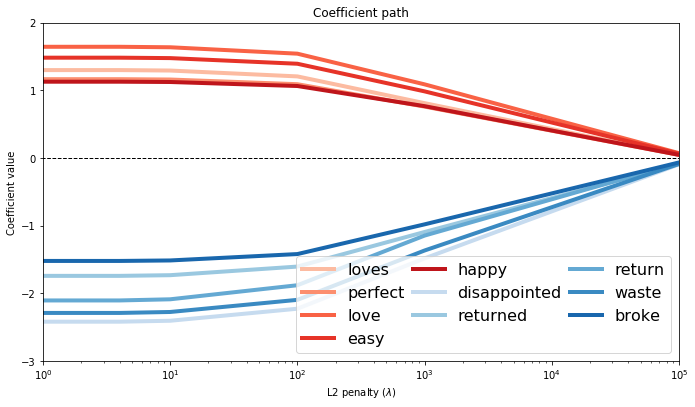

In [37]:
make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])

**Quiz Question**: (**True**/False) Overall, all coefficients generally get smaller in size as the L2 penalty is increased.